# Chercher le texte

In [1]:
import requests
from bs4 import BeautifulSoup

# URL de la page web à scraper
url = 'http://www.theatre-classique.fr/pages/programmes/PageEdition.php'

# Faites une requête HTTP pour obtenir le contenu de la page
response = requests.get(url)

# Vérifiez si la requête a réussi (statut code 200)
if response.status_code == 200:
    # Utilisez BeautifulSoup pour analyser le contenu HTML de la page
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Créez une liste vide pour stocker les éléments href se terminant par '.txt'
    txt_links = []
    
    # Trouvez tous les éléments <a> ayant un attribut href se terminant par '.txt'
    elements = soup.find_all('a', href=lambda href: href and href.endswith('.txt'))

    # Parcourez les éléments trouvés et modifiez l'attribut href pour remplacer '../txt/' par 'http://www.theatre-classique.fr/pages/txt/'
    for element in elements:
        href_value = element['href']
        new_href = href_value.replace('../txt/', 'http://www.theatre-classique.fr/pages/txt/')
        element['href'] = new_href
    # et ajoutez leur contenu (liens) à la liste txt_links
        txt_links.append(new_href)
else:
    print('La requête a échoué avec le code de statut :', response.status_code)

# Affichez la liste des liens .txt
#print(txt_links)

# Enregistrer le texte

In [2]:
import random
doc_list = []
for i in [random.randint(1, 1000) for _ in range(5)]:
    if txt_links[i]:
        # Récupérez l'URL du fichier texte
        file_url = txt_links[i]
        #print('file_url OK')

        # Faites une requête HTTP pour télécharger le contenu du fichier texte
        file_response = requests.get(file_url)
        #print('file_response OK')

        # Vérifiez si le téléchargement a réussi (statut code 200)
        if file_response.status_code == 200:
            # Enregistrez le contenu dans un fichier local (par exemple "doc.txt")
            doc = os.path.basename(txt_links[i])
            doc_list.append(doc)
            with open(doc, 'wb') as file:
                file.write(file_response.content)
            #print("Le fichier a été téléchargé avec succès.\n")
        else:
            pass
            #print("Le téléchargement du fichier a échoué avec le code de statut :", file_response.status_code)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Concatener le texte

In [3]:
df_tot = pd.DataFrame()
for i in doc_list : 
    df=pd.read_fwf(i,header=None,sep=" ",encoding = "ISO-8859-1")
    #print(df.shape)
    df_tot = pd.concat([df_tot,df],ignore_index=True)
    #print(df_tot.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Tokenizer le texte

In [4]:
%%time
# On enlève la ponctuation et on tokenize
from nltk.tokenize import RegexpTokenizer
for c in range(0,df_tot.shape[1]):
    for r in range(0,len(df_tot)):
        if type(df_tot.iloc[r,c]) == str :
            tokenizer = RegexpTokenizer(r'\w+')
            df_tot.at[r,c] = tokenizer.tokenize(df_tot.iloc[r,c])

CPU times: total: 34.7 s
Wall time: 36 s


In [5]:
# Rassembler les lignes dans une colonne "cleaned"
from functools import reduce
col = []
for i in range(0, len(df_tot)):
    col.append(reduce(lambda x,y : x+y if (type(x) == list and type(y) == list) else x, df_tot[i:i+1].values.tolist()[0]))
df_tot["cleaned"] = col

In [6]:
# réduire df_tot à cette colonne
#df_tot = df_tot.loc[:,'cleaned']

# Labelliser

In [7]:
# note
def note(x):
    if 'note' in x:
        return 'note'
    else:
        pass

# personnage    
def personnage(x):
    try:
        if x[0].isupper():
            return 'personnage'
    except:
        pass

# structure
def structure(x):
    if  ('acte' or 'scène') in x:
        return 'structure'
    else:
        pass

#df_tot['label'] = df_tot['cleaned'].map(lambda x: note(x))
df_tot['label'] = df_tot['cleaned'].map(lambda x: personnage(x))
#df_tot['label'] = df_tot['cleaned'].map(lambda x: structure(x))

In [8]:
# Réduire aux deux colonnes essentielles
df_tot = df_tot.loc[:,['cleaned', 'label']]

In [9]:
# Supprimer les lignes pour lesquelles la valeur est [] dans la colonne 'cleaned'
df_tot = df_tot[df_tot['cleaned'] != '[]']

In [10]:
# Sauvegarder ce dataset
df_tot.to_csv("train_test_set.csv", index=False, sep=';')

# Modelisation

## Le modèle entraîné détectera les notes et la structure en prenant la pièce à partir d'"acte premier"

In [11]:
# General
import pyforest
import time

# Sklearn
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

# Tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Bert
import os
import transformers
from transformers import *
os.environ["TF_KERAS"]='1'

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

C:\Users\John\Desktop\Formation\venv\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
C:\Users\John\Desktop\Formation\venv\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


Num GPUs Available:  0


In [12]:
# Load database
df = pd.read_csv('train_test_set_.csv', sep=';')

<IPython.core.display.Javascript object>

In [13]:
# Réduction du dataset aux labels "structure" et "note" 
df = df[(df.label=='structure')| (df.label=='note')].reset_index(drop=True)

In [14]:
# Vérification du type des éléments dans la colonne 'cleaned'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cleaned  144 non-null    object
 1   label    144 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [15]:
import ast
assert type(ast.literal_eval(df['cleaned'][5]))==list, print('type df[\'cleaned\'] incorrect')

In [16]:
#on va transformer les objets dans la colonne cleaned en un string séparé par des espaces
for i, x in enumerate(df['cleaned']):
    try:
        df.loc[i, 'cleaned'] = ast.literal_eval(x)[0:7]
    except:
        continue
        
df['cleaned'] = list(map(lambda x : ' '.join(x), df['cleaned']))

In [17]:
# Function to color the confusion matrix
def color(val):
    
    color = 'mediumaquamarine' if val > 0 else ''
    return 'background-color: %s' % color

In [18]:
%%time

text_list = list(df['cleaned'])

# Count_vectorizer method
t1 = time.time()
count_cv = CountVectorizer()
tf_cv = count_cv.fit_transform(text_list)
tf_feature_names_cv = count_cv.get_feature_names_out()
t_cv_ = time.time() -t1

#Tf-idf method
t1 = time.time()
count_tf = TfidfVectorizer()
tf_tf = count_tf.fit_transform(text_list)
tf_feature_names_tf = count_tf.get_feature_names_out()
t_tf_ = time.time() -t1

# Preview database encoded with bag of words

cv = pd.DataFrame(tf_cv.toarray(), columns = tf_feature_names_cv) / len(tf_feature_names_cv)
cv.style.set_caption("Term Frequency of Document")
cv.style.applymap(color)
cv.head()

tf = pd.DataFrame(tf_tf.toarray(), columns = tf_feature_names_tf) / len(tf_feature_names_tf)
tf.style.set_caption("Term Frequency of Document")
tf.style.applymap(color)

print('Term Frequency of Document')
#cv
#tf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Term Frequency of Document
CPU times: total: 906 ms
Wall time: 1.04 s


In [19]:
assert len(cv)==len(df['label']), print('len(cv) n\'est pas égal à len(df[\'label\'])')

In [20]:
# Add the labels to the database encoded with bag of words
df_cv = pd.concat([cv,df['label']], axis=1)
df_tf = pd.concat([tf,df['label']], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## T-SNE et clustering

In [21]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vraies catégories et n° de clusters
def ARI_fct(features, l_cat) :
    time1 = time.time()
    num_labels=len(set(l_cat))
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    
    # #Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_, time2


# Visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(y_cat_num), loc="best", title="Categorie")#--------------l_cat
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [22]:
# Record performance
perf = [['model', 'ARI', ' prediction time(seconds)']]

## 1st approach : BOW – CountVectorizer

In [23]:
# Définition of X and y
df_ = df_cv
X = df_.drop(columns='label')
y= df_['label']
y_cat_num = LabelEncoder().fit_transform(y)

# X and y split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
    test_size=0.3,
    random_state=42
                    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Display performance
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels, t_cv = ARI_fct(X,y)

CountVectorizer : 
-----------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ARI :  0.0379 time :  2.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

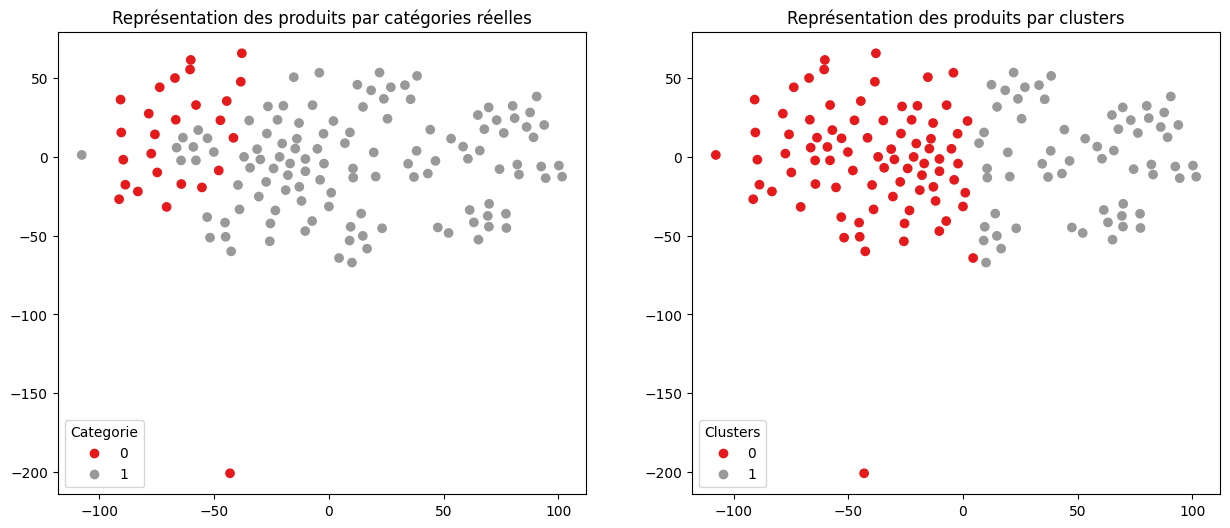

ARI :  0.0379


In [25]:
# Vizualising T-sne for True and Predicted
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [26]:
# Appending the performance log
perf.append(['CountVectorizer',"{:.2f}".format(ARI), "{:.2f}".format(t_cv)])

## 2nd approach : BOW – TfidfVectorizer

In [27]:
# Définition of X and y
df_ = df_tf
X = df_.drop(columns='label')
y= df_['label']
y_cat_num = LabelEncoder().fit_transform(y)

# X and y split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
    test_size=0.3,
    random_state=42
                    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Display performance
print("TfidfVectorizer : ")
print("-----------------")
ARI, X_tsne, labels, t_tf = ARI_fct(X,y)

TfidfVectorizer : 
-----------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ARI :  0.1474 time :  3.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

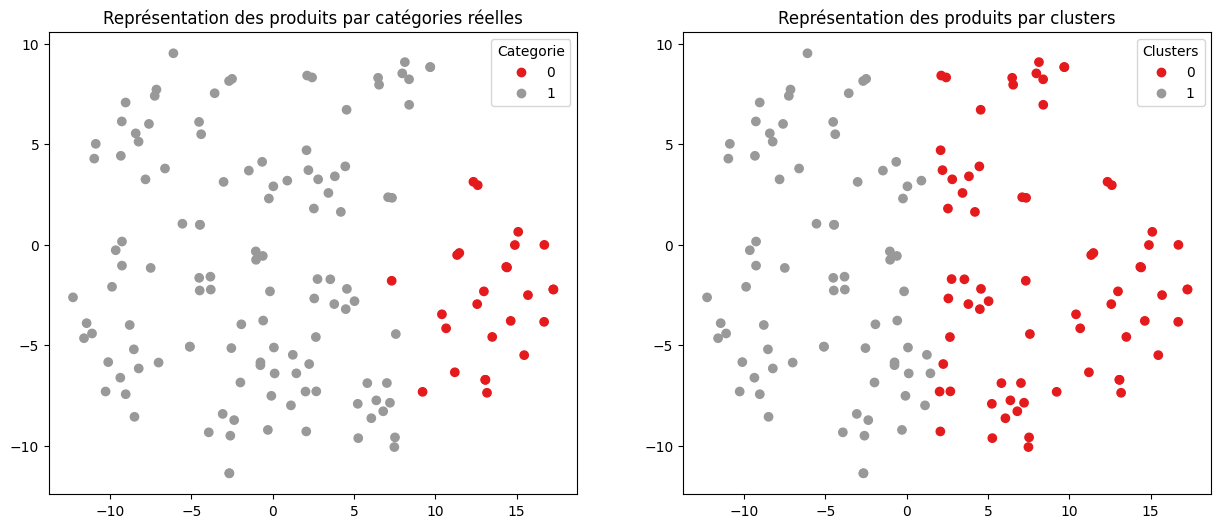

ARI :  0.1474


In [29]:
# Vizualising T-sne for True and Predicted
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [30]:
# Appending the performance log
perf.append(['TfidfVectorizer',"{:.2f}".format(ARI),"{:.2f}".format(t_tf)])

In [31]:
import pprint
pp = pprint.PrettyPrinter(indent=4)  # Create a PrettyPrinter instance with an indent of 4 spaces
pp.pprint(perf) 

[   ['model', 'ARI', ' prediction time(seconds)'],
    ['CountVectorizer', '0.04', '2.00'],
    ['TfidfVectorizer', '0.15', '3.00']]


# 3rd approach : word embedding – Word2Vec

In [32]:
# Additional libraries for Word2Vec
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [33]:
# Instanciation du modèle Word2Vec

# Initialisation

#{'workers': 11, 'negative': 5, 'vector_size': 300, 'sample': 0, 'min_count': 1, 'dm': 0}

w2v_sg=1
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 7 # adapt to length of sentences
sentences = df['cleaned'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

#w2v_model = Word2Vec(sg=0,min_count=1,window=3)#,workers=cores-1) size=100,
#w2v_model.build_vocab(df.tokenized, progress_per=1000)

# Création du modèle Word2Vec

w2v_model = gensim.models.Word2Vec(sg=w2v_sg,
                                                min_count=w2v_min_count, 
                                                window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())

In [34]:
%%time
# Entraînement du modèle Word2Vec

print("train Word2Vec model ...")
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

train Word2Vec model ...
Vocabulary size: 171
Word2Vec trained
CPU times: total: 594 ms
Wall time: 485 ms


In [35]:
%%time
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 172
CPU times: total: 0 ns
Wall time: 5.22 ms


In [36]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Word embedding rate :  1.0
Embedding matrix: (172, 300)


In [37]:
# Création du modèle d'embedding

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 embedding (Embedding)       (None, 7, 300)            51600     
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 51,600
Trainable params: 51,600
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Execution du modèle d'embedding

t1 = time.time()
embeddings = embed_model.predict(x_sentences)
embeddings.shape
t_wv_ = time.time() - t1

5/5 [==============================] - 0s 6ms/step


In [39]:
# Display performance
ARI, X_tsne, labels, t_wv = ARI_fct(embeddings,y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ARI :  0.1168 time :  3.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

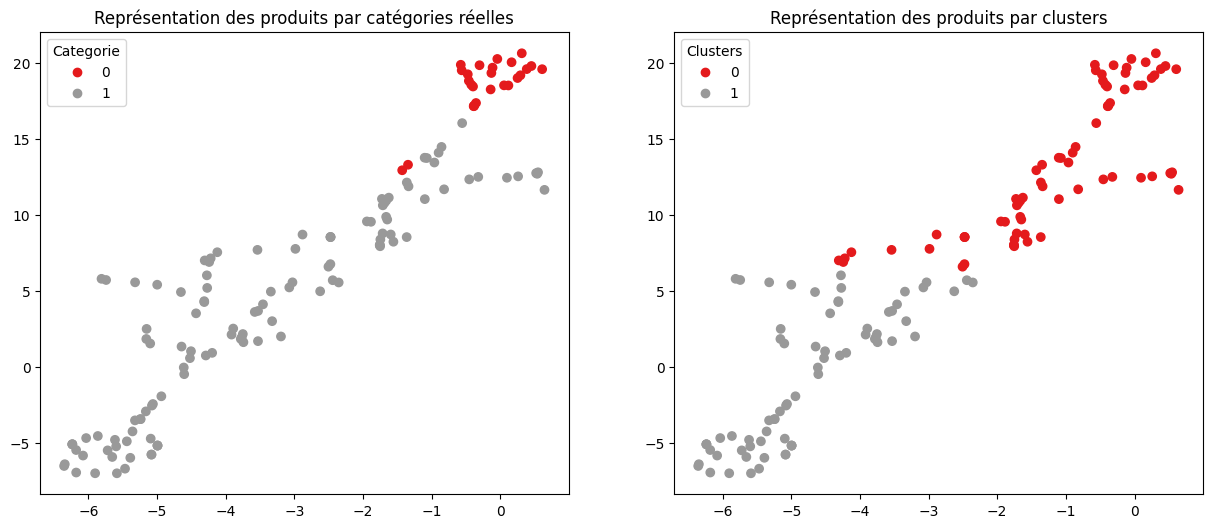

ARI :  0.1168


In [40]:
#Vizualising True and Pred
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [41]:
# record performance
perf.append(['Word2Vec',"{:.2f}".format(ARI), "{:.2f}".format(t_wv)])

# 4th approach : BERT

In [42]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [43]:
# Parameters for BERT
max_length = 7
batch_size = 1
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['cleaned'].to_list()

loading configuration file config.json from cache at C:\Users\John/.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\John/.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076

In [44]:
%%time
# Création des features
t1 = time.time()
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')
t_be_ = time.time() - t1

loading configuration file config.json from cache at C:\Users\John/.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\John/.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\vocab.txt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 9s 9s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 99ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 81ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 80ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 80ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 86ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 97ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 82ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 90ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 91ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 103ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 85ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 97ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 80ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 81ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 84ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 97ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 75ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 96ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 97ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 82ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 105ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 92ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 85ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 139ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 110ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 106ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 109ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 84ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 95ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 88ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 86ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 86ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 100ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 93ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 88ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 82ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 90ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 89ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 89ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 81ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 96ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 73ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 72ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 73ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 81ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 82ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 86ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 91ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 81ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 82ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 72ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 76ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 93ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 90ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 98ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 98ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 77ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 90ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 93ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 79ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 77ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 81ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 99ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 86ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 77ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 84ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 72ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 99ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 102ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 72ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 82ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 98ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 76ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 86ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 80ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 95ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 85ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 79ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 87ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 77ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 73ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 80ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 83ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 90ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 98ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 91ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 92ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 73ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 80ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 80ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 84ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 85ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 90ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

temps traitement :  38.0
CPU times: total: 57 s
Wall time: 38.5 s


In [45]:
# Display performance
ARI, X_tsne, labels, t_be = ARI_fct(features_bert,y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ARI :  0.0885 time :  2.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

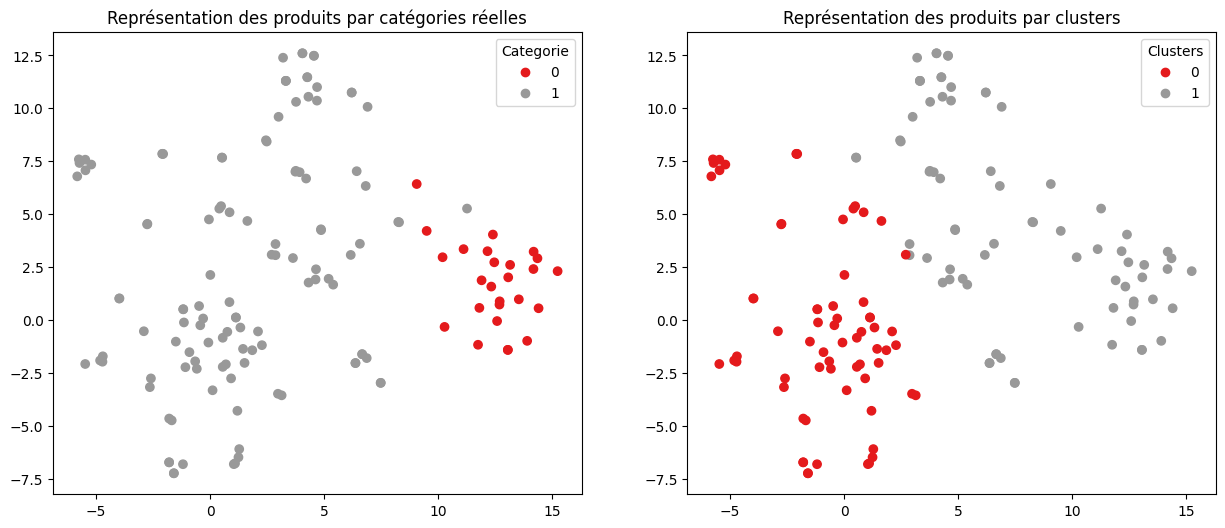

ARI :  0.0885


In [46]:
# Vizualising True and Pred
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [47]:
# Record performance
perf.append(['BERT',"{:.2f}".format(ARI), "{:.2f}".format(t_be)])

# 5th approach : Word embedding – USE

In [48]:
# Additional library for USE
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [49]:
# Preprocessing the data for USE
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

batch_size = 8
sentences = df['cleaned'].to_list()

In [50]:
%%time
# Création des features
t1= time.time()
features_USE = feature_USE_fct(sentences, batch_size)
t_us = time.time() - t1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: total: 938 ms
Wall time: 920 ms


In [51]:
# Display performance
ARI, X_tsne, labels, t_us = ARI_fct(features_USE, y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ARI :  0.4739 time :  2.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

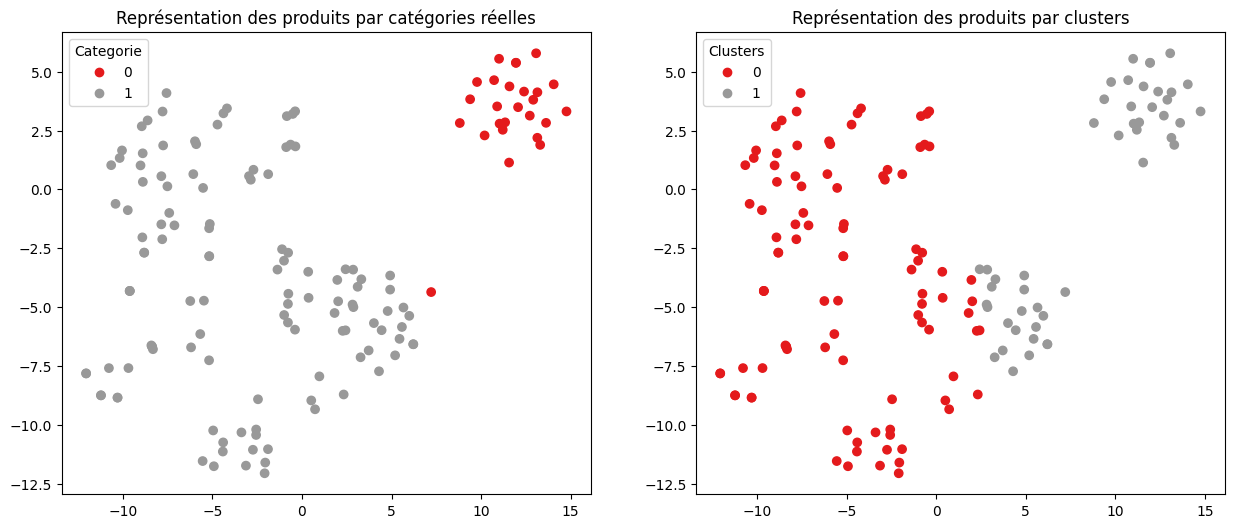

ARI :  0.4739


In [52]:
# Vizualising True and Pred
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [53]:
perf.append(['USE',"{:.2f}".format(ARI),"{:.2f}".format(t_us)])

In [54]:
pd.DataFrame(perf[1:], columns=perf[0])

<IPython.core.display.Javascript object>

,model,ARI,prediction time(seconds)
0,CountVectorizer,0.04,2.00
1,TfidfVectorizer,0.15,3.00
2,Word2Vec,0.12,3.00
3,BERT,0.09,2.00
4,USE,0.47,2.00


In [55]:
# On recontruit la base avec la meilleur prédiction
df['pred'] = labels

In [56]:
# On va changer les valeurs numériques des labels par leurs valeurs textuelles
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment

# Supposons que vous ayez déjà chargé votre DataFrame dans une variable df

# Créer la matrice de confusion
confusion_matrix = pd.crosstab(df['label'], df['pred'], rownames=['Réel'], colnames=['Prédit'])

# Convertir la matrice de confusion en un tableau numpy
confusion_matrix_array = confusion_matrix.to_numpy()

# Utiliser la méthode hongroise pour trouver la meilleure correspondance entre les classes
row_ind, col_ind = linear_sum_assignment(-confusion_matrix_array)

# row_ind contient les index des classes réelles, col_ind contient les index des classes prédites
# Les valeurs correspondantes dans les deux listes sont les appariements optimaux

# Vous pouvez utiliser ces appariements pour obtenir les classes réelles correspondantes aux classes prédites
correspondances = {label_index: pred_index for label_index, pred_index in zip(row_ind, col_ind)}

# Afficher les correspondances
for label_index, pred_index in correspondances.items():
    print(f"Classe réelle : {confusion_matrix.index[label_index]}, Classe prédite : {confusion_matrix.columns[pred_index]}")


Classe réelle : note, Classe prédite : 1
Classe réelle : structure, Classe prédite : 0


In [57]:
dic = dict(zip(confusion_matrix.columns.tolist()[::-1],confusion_matrix.index.tolist()))
dic

{1: 'note', 0: 'structure'}

In [58]:
# on crée une colonne avec les valeurs textuelles prédites
df['pred_label'] = [dic[x] for x in df['pred']]

In [59]:
# raw confusion matrix
conf_mat = metrics.confusion_matrix(df['label'], df['pred_label'])
print(conf_mat)

[[26  0]
 [21 97]]


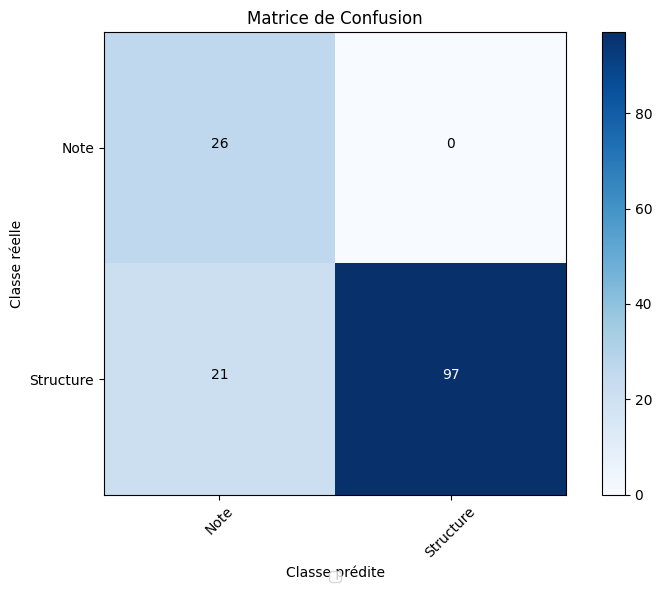

In [60]:
# un beau visuel de la matrice de confusion
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Exemple de matrice de confusion (vous devrez utiliser votre propre matrice ici)
#conf_mat = np.array([[85, 10],
#                     [15, 90]])

# Labels des classes
#class_labels = ["Classe 0", "Classe 1"]
class_labels = ["Note", "Structure"]

# Création de la figure et de l'axe
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotation des valeurs de la matrice
thresh = conf_mat.max() / 2.0
for i, j in np.ndindex(conf_mat.shape):
    plt.text(j, i, format(conf_mat[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_mat[i, j] > thresh else "black")

plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.tight_layout()

# Affichage de la légende
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, labels=class_labels)

# Affichage de la figure
plt.show()

## Conclusion : l'algorithme prédit sans se tromper les éléments de structure mais fait beaucoup trop d'erreurs pour les notes. Il pourrait être utile de rééquilibrer les effectifs des classes pendant l'apprentissage


# Extraction des listes de personnage et de structure

In [61]:
#Load database
df = pd.read_csv('train_test_set_.csv', sep=';')

In [62]:
# liste des structures
import ast
set([(ast.literal_eval(x)[0],ast.literal_eval(x)[1])  for x in df.loc[df['label']=='structure','cleaned']])

{('ACTE', 'I'),
 ('ACTE', 'II'),
 ('ACTE', 'III'),
 ('ACTE', 'IV'),
 ('ACTE', 'V'),
 ('SCÈNE', 'DERNIÈRE'),
 ('SCÈNE', 'I'),
 ('SCÈNE', 'II'),
 ('SCÈNE', 'III'),
 ('SCÈNE', 'IV'),
 ('SCÈNE', 'IX'),
 ('SCÈNE', 'PREMIÈRE'),
 ('SCÈNE', 'V'),
 ('SCÈNE', 'VI'),
 ('SCÈNE', 'VII'),
 ('SCÈNE', 'VIII'),
 ('SCÈNE', 'X'),
 ('SCÈNE', 'XI'),
 ('SCÈNE', 'XII'),
 ('SCÈNE', 'XIII'),
 ('SCÈNE', 'XIV'),
 ('SCÈNE', 'XIX'),
 ('SCÈNE', 'XIÏ'),
 ('SCÈNE', 'XV'),
 ('SCÈNE', 'XVI'),
 ('SCÈNE', 'XVII'),
 ('SCÈNE', 'XVIII')}

In [63]:
# Liste des noms
tnom = df.loc[df['label']=='personnage','cleaned']
lnomr=[]
for lnom in tnom:
    nomp = []
    for i in ast.literal_eval(lnom):
        if i.isupper():
            nomp.append(i)
        else:
            break
    lnomr.append(nomp)
lnomr[0:5]    

[['EUPHÉMIE'], ['FROSINE'], ['SOSTRATE'], ['STRATON'], ['CHRISANTE']]

In [64]:
# Utilisation d'une boucle pour ajouter chaque sous-liste en tant qu'élément du set
data_set = set()
for sublist in lnomr:
    data_set.add(tuple(sublist))

print(data_set)

{('MONSIEUR', 'DU', 'PAS'), ('EUGÈNE',), ('JARWIS',), ('UN', 'CUISINIER'), ('AIR',), ('C',), ('EUPHÉMIE',), ('LA', 'FRANCE'), ('LÉANDRE',), ('ISABELLE',), ('N',), ('LE', 'MARQUIS'), ('CAROLINE',), ('JARWIS', 'D', 'HARVILLIERS', 'EUGÈNE', 'ALBERT'), ('LUCILE',), ('LES', 'MATELOTS'), ('ALBERT', 'DE', 'CHAMP', 'ROSÉ'), ('Ô',), ('LISETTE',), ('ALBERT',), ('ALBERT', 'D', 'HARVILLIERS', 'EUGÈNE', 'CAROLINE'), ('LE', 'MAÎTRE'), ('MONSIEUR', 'DE', 'FORLIS'), ('LE', 'LAQUAIS'), ('CHOEUR', 'DE', 'MATELOTS'), ('LE', 'COMTE'), ('ALBERT', 'D', 'HARVILLIHERS'), ('D', 'HARVILLIERS'), ('CÉLIANTE',), ('GUILLAUME', 'JARWIS'), ('LE', 'CUISINIER'), ('TOUS',), ('LICAS',), ('GILLES',), ('M', 'DCC', 'LXVIII'), ('STRATON',), ('PAR', 'MM', 'XAVIER', 'ET', 'DUVERT'), ('SOSTRATE',), ('CHRISANTE',), ('S',), ('L', 'HOMME', 'DU', 'JOUR'), ('FROSINE',), ('LE', 'BARON'), ('LE', 'COMTE', 'D', 'ORVILLE'), ('ODÉINA',), ('MEDWIN',), ('UN', 'LAQUAIS'), ('ODÉIRA',), ('LE', 'MAÎTRE', 'DE', 'BALLETS'), ('À',), ('CHAMPAGNE',)